# Flair Classification

In [236]:
import numpy as np
import pandas as pd
from train import _get_cleaned_dataframe

In [237]:
import matplotlib.pyplot as plt
%matplotlib inline

In [238]:
data = _get_cleaned_dataframe()

In [239]:
data.head()

,comments,flair,permalink,poster,selfpost,selftext,timestamp,title,upvotes
0,"[{'author': 'HANDSOME_RHYS', 'body': 'I knew S...",Politics,/r/india/comments/cyj7gz/kashmir_news_coverage_3/,gujjuben,True,A summary of news coverage on Kashmir in the p...,"[{'author': 'HANDSOME_RHYS', 'body': 'I knew S...",Kashmir News Coverage - 3,102
1,"[{'author': 'NihilistLurker', 'body': 'I appre...",[R]eddiquette,/r/india/comments/czue7z/happy_teachers_day/,R4V3N11,True,Big thanks to all the teachers who have taught...,"[{'author': 'NihilistLurker', 'body': 'I appre...",Happy Teachers Day,72
2,"[{'author': '5h1v4u', 'body': 'Good for what y...",[R]eddiquette,/r/india/comments/czwtnd/i_work_in_medical_sto...,meetu007,True,"Because she can't afford transport,so I took h...","[{'author': '5h1v4u', 'body': 'Good for what y...","I work in medical store, today 10 year old gir...",602
3,"[{'author': 'FresnoMac', 'body': 'What's parti...",Politics,/r/india/comments/czvagp/i_transcribed_the_ful...,firasd,True,*Transcript of the remarks by Indiaâ€™s former...,"[{'author': 'FresnoMac', 'body': 'What's parti...",I transcribed the full text of Dr. Manmohan Si...,485
4,"[{'author': 'angrybong', 'body': 'Congress is ...",Politics,/r/india/comments/czwmff/shashi_tharoor_i_am_a...,computerbaba7,False,,"[{'author': 'angrybong', 'body': 'Congress is ...",Shashi Tharoor: I am a proud Hindu because my ...,164


## Class Imbalance

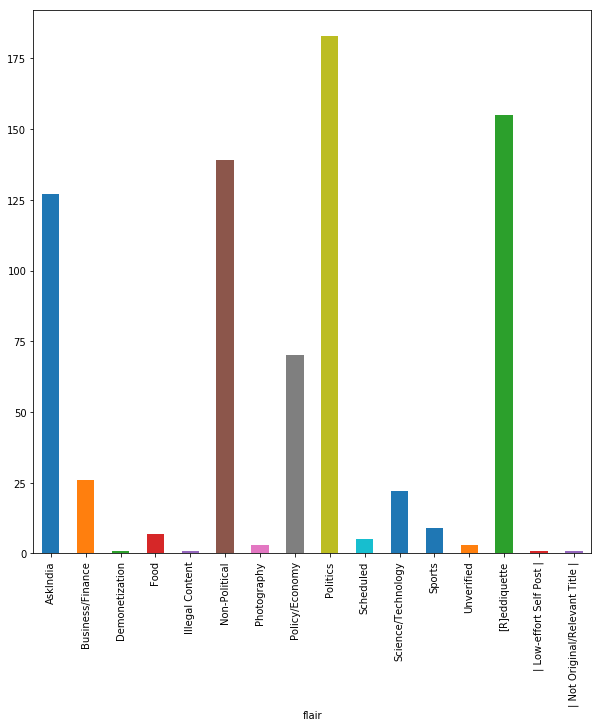

In [240]:
fig = plt.figure(figsize=(10, 10))

data.groupby('flair').title.count().plot.bar(ylim=0)
plt.show()

In [241]:
""" 
Drop 4 classes 

- Demonetization
- Illegal Content
- | Low-effort Self Post |
- | Not Original/Relevant Title |

"""
drop_classes = [
        "Demonetization",
        "Illegal Content",
        "| Low-effort Self Post |",
        "| Not Original/Relevant Title |"
    ]

for cls in drop_classes:
    data = data[data["flair"] != cls]

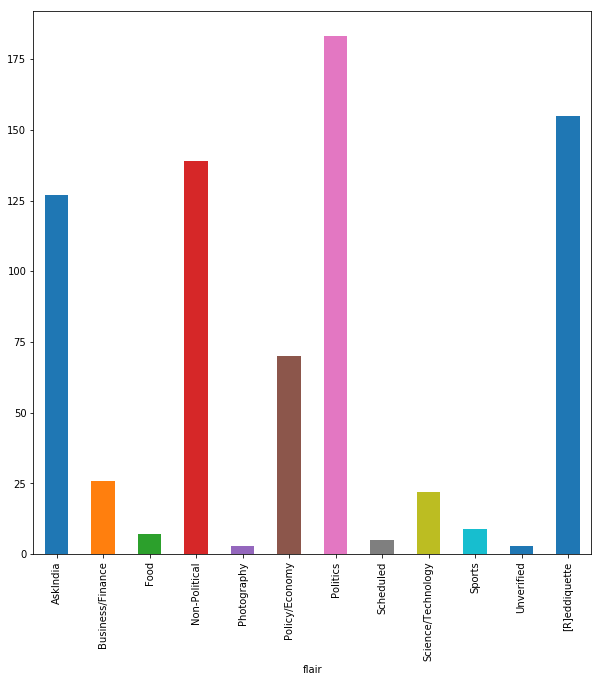

In [242]:
fig = plt.figure(figsize=(10, 10))

data.groupby('flair').title.count().plot.bar(ylim=0)
plt.show()

# Vectorization

In [284]:
def _concatenate_features(df, features):
    feature_dict = {
        "feature" : []
    }
    for index, row in df.iterrows():
        data = ""
        for feature in features:
            if feature == "comments":
                comment_string = ""
                for comment in row["comments"]:
                    comment_string += comment["body"]
                data += comment_string
            else:
                data += row[feature]
        feature_dict["feature"].append(data)
            
    return pd.DataFrame(feature_dict)

In [285]:
# concat_df = _concatenate_features(data, ["title", "permalink", "selftext"])
concat_df = _concatenate_features(data, ["title", "permalink", "comments", "selftext"])

concat_df.shape

(749, 1)

In [286]:
concat_df["feature"][0]

'Kashmir News Coverage - 3/r/india/comments/cyj7gz/kashmir_news_coverage_3/I knew Satypal was a thicc but I didn\'t realize he was \'dense\' thick.Situation in Kashmir is Normal.\n\nHowever, if someone else tries to check the situation , the situation would get dangerous !\n\nSo, stay at home & listen to what the governor says.\n\n:(It is so appalling how the Indian media has covered it. Most of the media (with the notable exceptions like The Wire, The Quint, Telegraph and The Hindu) has been acting like a state propaganda machine. I had never imagined that I would see anything like this happen in my country and to this extent. We really are living in a post-truth world.There is no war in Ba Sing Se.Great to have Kashmir news thread back again. Thanks to  [u/gujjuben](https://www.reddit.com/user/gujjuben/) for this. Things are far from normal. It will take some time and news about Kashmir is hard to get.Current situation of political leaders\n\nCaged like the separatists meanwhile the 

In [287]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
flair = data.flair
le = le.fit(flair)
labels = le.transform(data.flair)

In [288]:
# https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    sublinear_tf=True, 
    min_df=5, 
    norm='l2', 
    encoding='latin-1', 
    ngram_range=(1, 2), 
    stop_words='english'
)

features = tfidf.fit_transform(concat_df.feature).toarray()
features.shape

(749, 7860)

In [289]:
classes = data.flair.unique()

## Feature Selection

In [290]:
from sklearn.feature_selection import chi2
import numpy as np

N = 12

for category in classes:
  features_chi2 = chi2(features, labels == le.transform((category,))[0])
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(category))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))


# 'Politics':
  . Most correlated unigrams:
. bail
. muslim
. politics
. amit
. assam
. election
. shah
. modi
. pakistan
. bjp
. kashmir
. nrc
  . Most correlated bigrams:
. narendra modi
. assam nrc
. human rights
. bjp india
. https thewire
. rahul gandhi
. madhya pradesh
. nrc india
. kashmir india
. modi india
. pm modi
. amit shah
# '[R]eddiquette':
  . Most correlated unigrams:
. spirit
. upvotes
. mistaken
. attacks
. deaf
. female
. intimidating
. diary
. swamy
. zomato
. pregnant
. thrashed
  . Most correlated bigrams:
. daily discussion
. hai ki
. askaway creator
. bot bot
. bot problem
. problem askaway
. ho gayi
. hai jo
. people downvoting
. karte hai
. indian state
. subramanian swamy
# 'Non-Political':
  . Most correlated unigrams:
. tree
. stations
. police
. roads
. ganesha
. gurgaon
. km
. breaks
. dead
. traffic
. penalty
. fines
  . Most correlated bigrams:
. years india
. working class
. rs 23
. fines imposed
. traffic laws
. 23 000
. traffic violations
. report i

In [291]:
feature_df = concat_df
feature_df = feature_df.assign(flair=labels)
feature_df

,feature,flair
0,Kashmir News Coverage - 3/r/india/comments/cyj...,6
1,Happy Teachers Day/r/india/comments/czue7z/hap...,11
2,"I work in medical store, today 10 year old gir...",11
3,I transcribed the full text of Dr. Manmohan Si...,6
4,Shashi Tharoor: I am a proud Hindu because my ...,6
5,Mumbai Rains/r/india/comments/czvgch/mumbai_ra...,6
6,The good effects of new Motor Vehicle Act/r/in...,3
7,Clashes erupt in Kashmir after first civilian ...,11
8,Wish immigration was always like this. T3 Delh...,3
9,Human Rights Commission of Rajasthan issues or...,6


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(feature_df["feature"], feature_df["flair"], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)


C:\Users\arush\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\arush\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\arush\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\arush\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The mi

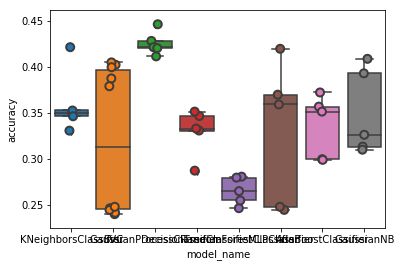

In [269]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB()
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)

sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()


In [270]:
cv_df.groupby('model_name').accuracy.mean()

model_name
AdaBoostClassifier           0.336147
DecisionTreeClassifier       0.330149
GaussianNB                   0.350605
GaussianProcessClassifier    0.425892
KNeighborsClassifier         0.360612
MLPClassifier                0.328556
RandomForestClassifier       0.265656
SVC                          0.319682
Name: accuracy, dtype: float64

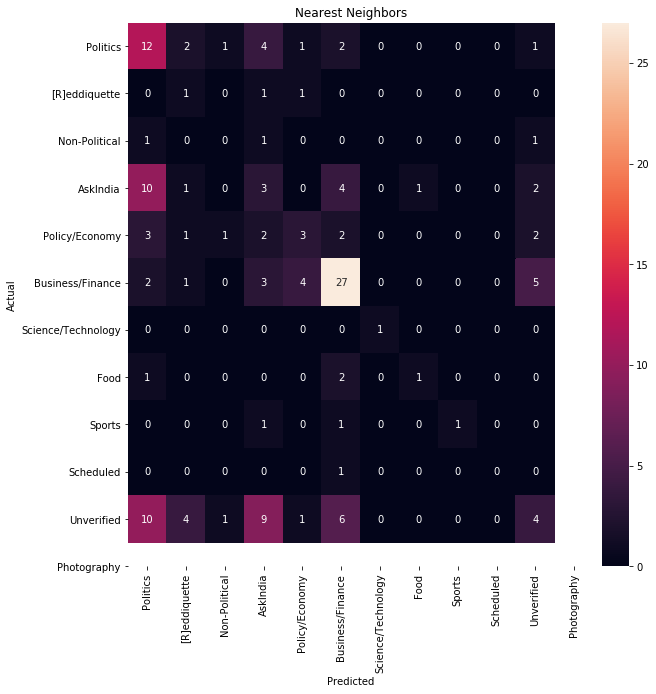

C:\Users\arush\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 11, does not match size of target_names, 12
  .format(len(labels), len(target_names))
C:\Users\arush\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                    precision    recall  f1-score   support

          Politics       0.31      0.52      0.39        23
     [R]eddiquette       0.10      0.33      0.15         3
     Non-Political       0.00      0.00      0.00         3
          AskIndia       0.12      0.14      0.13        21
    Policy/Economy       0.30      0.21      0.25        14
  Business/Finance       0.60      0.64      0.62        42
Science/Technology       1.00      1.00      1.00         1
              Food       0.50      0.25      0.33         4
            Sports       1.00      0.33      0.50         3
         Scheduled       0.00      0.00      0.00         1
        Unverified       0.27      0.11      0.16        35

       avg / total       0.36      0.35      0.34       150



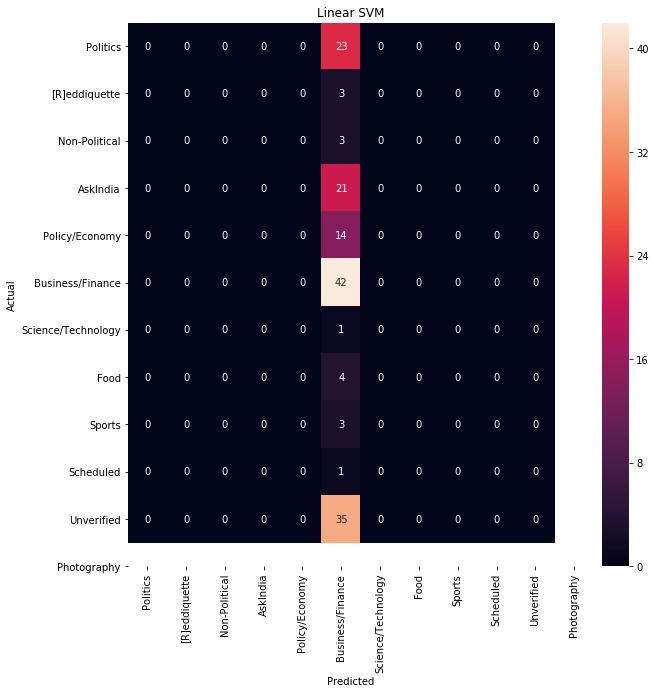

                    precision    recall  f1-score   support

          Politics       0.00      0.00      0.00        23
     [R]eddiquette       0.00      0.00      0.00         3
     Non-Political       0.00      0.00      0.00         3
          AskIndia       0.00      0.00      0.00        21
    Policy/Economy       0.00      0.00      0.00        14
  Business/Finance       0.28      1.00      0.44        42
Science/Technology       0.00      0.00      0.00         1
              Food       0.00      0.00      0.00         4
            Sports       0.00      0.00      0.00         3
         Scheduled       0.00      0.00      0.00         1
        Unverified       0.00      0.00      0.00        35

       avg / total       0.08      0.28      0.12       150



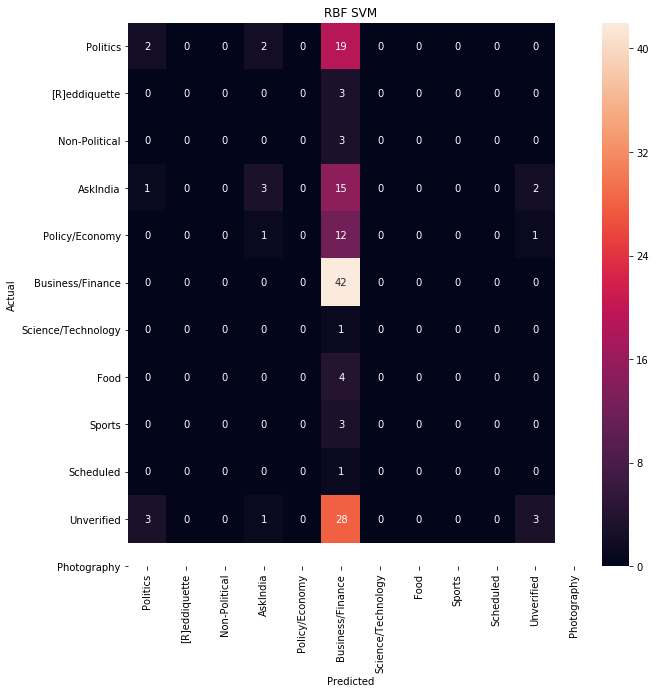

                    precision    recall  f1-score   support

          Politics       0.33      0.09      0.14        23
     [R]eddiquette       0.00      0.00      0.00         3
     Non-Political       0.00      0.00      0.00         3
          AskIndia       0.43      0.14      0.21        21
    Policy/Economy       0.00      0.00      0.00        14
  Business/Finance       0.32      1.00      0.49        42
Science/Technology       0.00      0.00      0.00         1
              Food       0.00      0.00      0.00         4
            Sports       0.00      0.00      0.00         3
         Scheduled       0.00      0.00      0.00         1
        Unverified       0.50      0.09      0.15        35

       avg / total       0.32      0.33      0.22       150



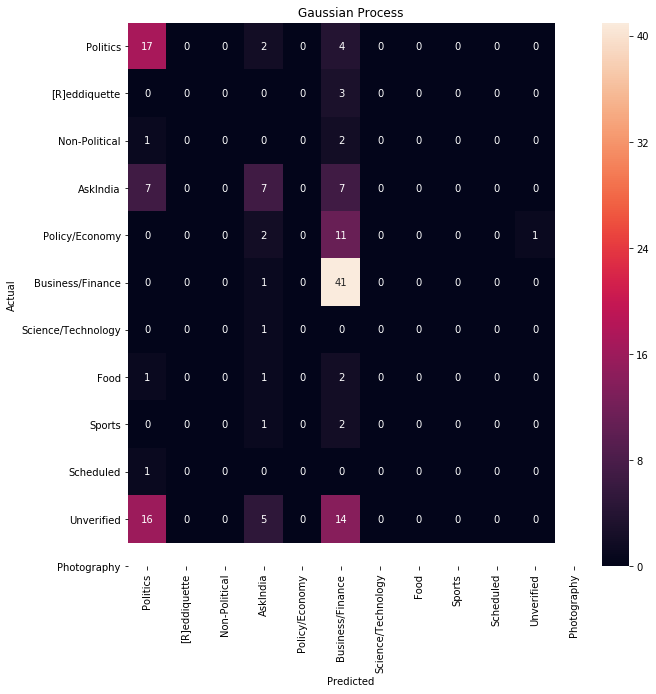

C:\Users\arush\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 11, does not match size of target_names, 12
  .format(len(labels), len(target_names))
C:\Users\arush\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                    precision    recall  f1-score   support

          Politics       0.40      0.74      0.52        23
     [R]eddiquette       0.00      0.00      0.00         3
     Non-Political       0.00      0.00      0.00         3
          AskIndia       0.35      0.33      0.34        21
    Policy/Economy       0.00      0.00      0.00        14
  Business/Finance       0.48      0.98      0.64        42
Science/Technology       0.00      0.00      0.00         1
              Food       0.00      0.00      0.00         4
            Sports       0.00      0.00      0.00         3
         Scheduled       0.00      0.00      0.00         1
        Unverified       0.00      0.00      0.00        35

       avg / total       0.24      0.43      0.31       150



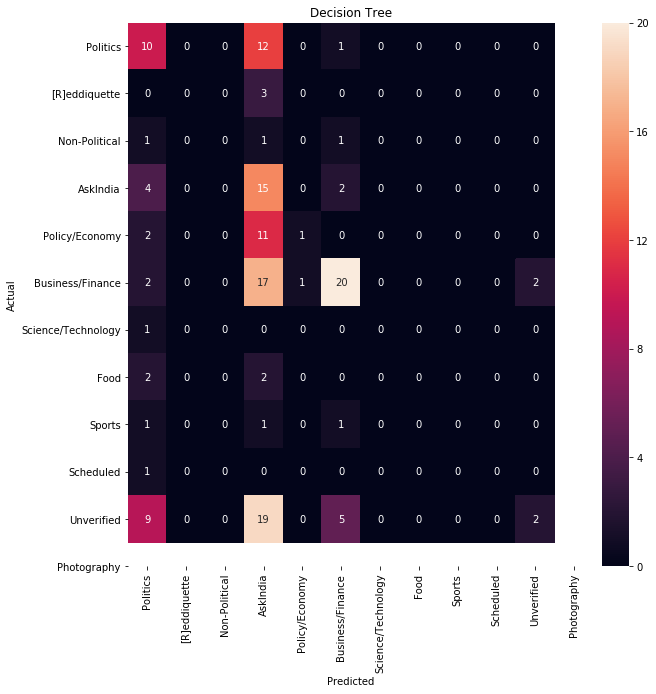

                    precision    recall  f1-score   support

          Politics       0.30      0.43      0.36        23
     [R]eddiquette       0.00      0.00      0.00         3
     Non-Political       0.00      0.00      0.00         3
          AskIndia       0.19      0.71      0.29        21
    Policy/Economy       0.50      0.07      0.12        14
  Business/Finance       0.67      0.48      0.56        42
Science/Technology       0.00      0.00      0.00         1
              Food       0.00      0.00      0.00         4
            Sports       0.00      0.00      0.00         3
         Scheduled       0.00      0.00      0.00         1
        Unverified       0.50      0.06      0.10        35

       avg / total       0.42      0.32      0.29       150



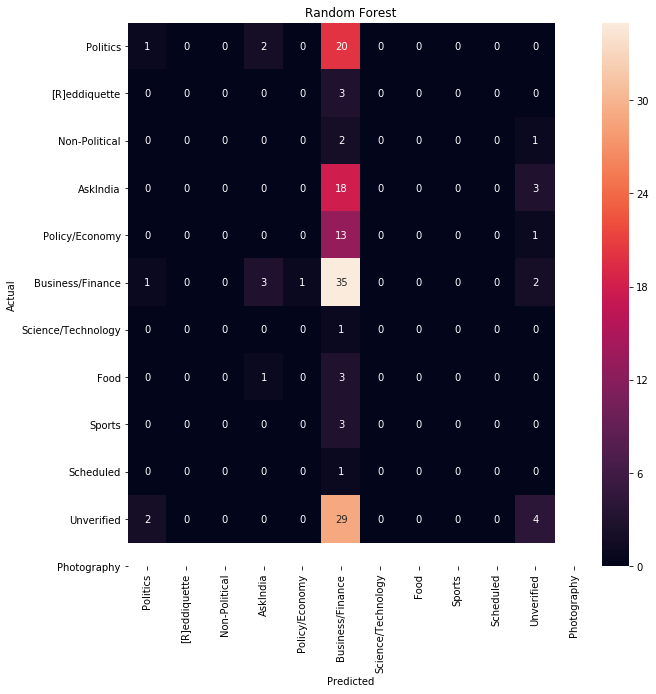

C:\Users\arush\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 11, does not match size of target_names, 12
  .format(len(labels), len(target_names))
C:\Users\arush\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                    precision    recall  f1-score   support

          Politics       0.25      0.04      0.07        23
     [R]eddiquette       0.00      0.00      0.00         3
     Non-Political       0.00      0.00      0.00         3
          AskIndia       0.00      0.00      0.00        21
    Policy/Economy       0.00      0.00      0.00        14
  Business/Finance       0.27      0.83      0.41        42
Science/Technology       0.00      0.00      0.00         1
              Food       0.00      0.00      0.00         4
            Sports       0.00      0.00      0.00         3
         Scheduled       0.00      0.00      0.00         1
        Unverified       0.36      0.11      0.17        35

       avg / total       0.20      0.27      0.17       150



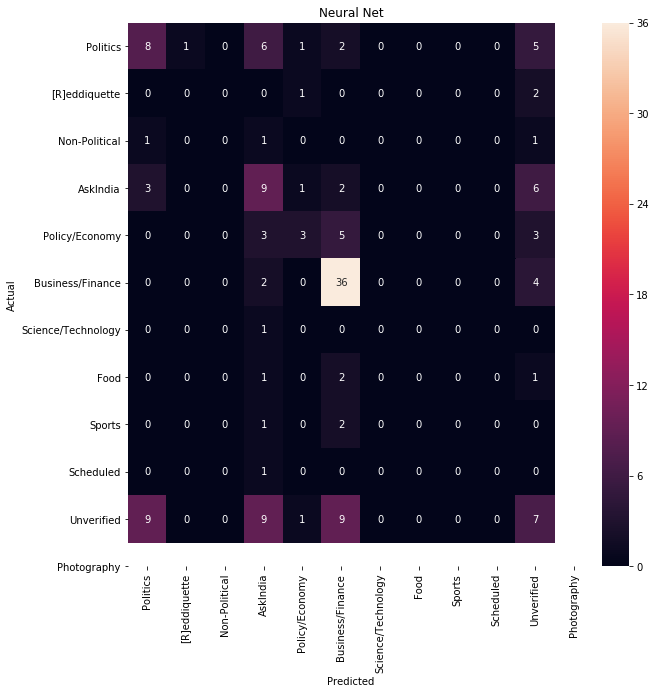

                    precision    recall  f1-score   support

          Politics       0.38      0.35      0.36        23
     [R]eddiquette       0.00      0.00      0.00         3
     Non-Political       0.00      0.00      0.00         3
          AskIndia       0.26      0.43      0.33        21
    Policy/Economy       0.43      0.21      0.29        14
  Business/Finance       0.62      0.86      0.72        42
Science/Technology       0.00      0.00      0.00         1
              Food       0.00      0.00      0.00         4
            Sports       0.00      0.00      0.00         3
         Scheduled       0.00      0.00      0.00         1
        Unverified       0.24      0.20      0.22        35

       avg / total       0.37      0.42      0.38       150



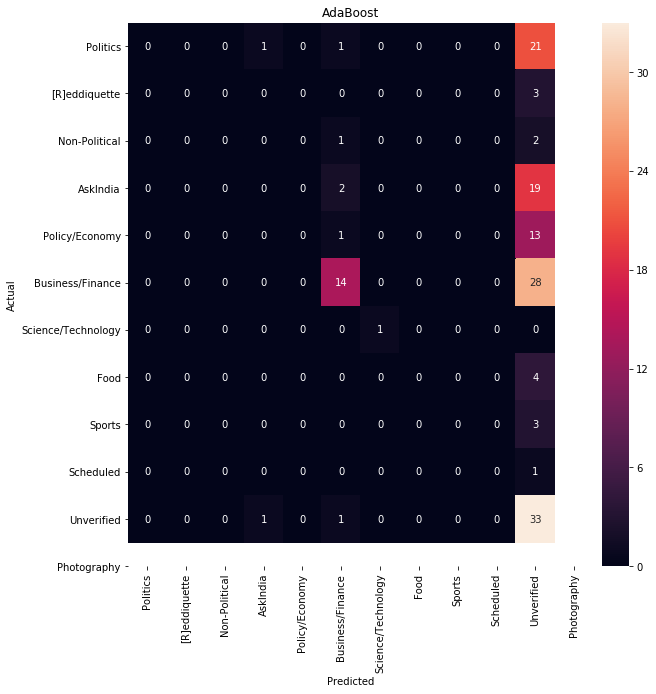

C:\Users\arush\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 11, does not match size of target_names, 12
  .format(len(labels), len(target_names))
C:\Users\arush\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                    precision    recall  f1-score   support

          Politics       0.00      0.00      0.00        23
     [R]eddiquette       0.00      0.00      0.00         3
     Non-Political       0.00      0.00      0.00         3
          AskIndia       0.00      0.00      0.00        21
    Policy/Economy       0.00      0.00      0.00        14
  Business/Finance       0.70      0.33      0.45        42
Science/Technology       1.00      1.00      1.00         1
              Food       0.00      0.00      0.00         4
            Sports       0.00      0.00      0.00         3
         Scheduled       0.00      0.00      0.00         1
        Unverified       0.26      0.94      0.41        35

       avg / total       0.26      0.32      0.23       150



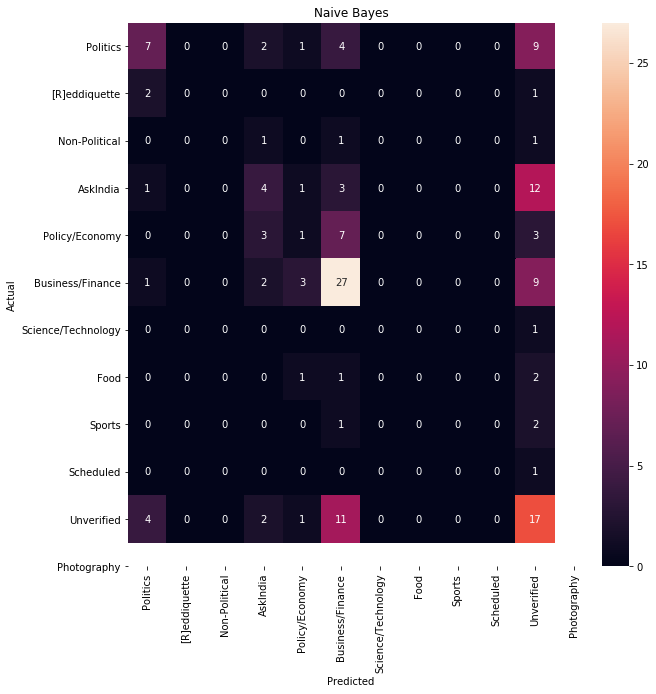

                    precision    recall  f1-score   support

          Politics       0.47      0.30      0.37        23
     [R]eddiquette       0.00      0.00      0.00         3
     Non-Political       0.00      0.00      0.00         3
          AskIndia       0.29      0.19      0.23        21
    Policy/Economy       0.12      0.07      0.09        14
  Business/Finance       0.49      0.64      0.56        42
Science/Technology       0.00      0.00      0.00         1
              Food       0.00      0.00      0.00         4
            Sports       0.00      0.00      0.00         3
         Scheduled       0.00      0.00      0.00         1
        Unverified       0.29      0.49      0.37        35

       avg / total       0.33      0.37      0.34       150



In [292]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


# models = [
#     RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
#     LinearSVC(),
#     MultinomialNB(),
#     LogisticRegression(random_state=0),
# ]

# names = [
#     "RandomForest",
#     "LinearSVC",
#     "Multinomial Naive Bayes",
#     "Logistic Regression"
# ]

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes"]

models = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB()
]

for (model, name) in zip(models, names):
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, data.index, test_size=0.2, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=data.flair.unique(), yticklabels=data.flair.unique())
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(name)
    plt.show()
    print(classification_report(y_test, y_pred, target_names=data.flair.unique()))
